## Final Notebook - Hotel Customer Reviews Analysis

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import wrangle
import unicodedata
from nltk.corpus import stopwords

### Project Overview:

- Notes...


### Project Goals:

- Notes...


### Data Acquisition:

- Notes...


### Data Wrangling:

- Notes...


In [2]:
df = wrangle.wrangle_hotel()
df.head()

Using cached csv file...


,month_name,month,year,day_name,day,quarter,hotel_name,street,city,zip_code,...,positive_unique_word_count,pos_lem_sentiment_score,negative_review,negative_clean_review,negative_stem,negative_lemma,positive_review,positive_clean_review,positive_stem,positive_lemma
0,August,8,2015,Tuesday,4,3,Hilton London Metropole,225 Edgware Road Westminster Borough,London,W2 1JU,...,6,0.4019,First day the swimming pool was not opened th...,first day swimmig pool ot opeed therefore coul...,first day swimmig pool ot ope therefor could o...,first day swimmig pool ot opeed therefore coul...,The hotel was clean and accessible,hotel clean accessible,hotel clean access,hotel clean accessible
1,August,8,2015,Tuesday,4,3,Hotel Mademoiselle,7 Rue des Petits H tels 10th,Paris,arr 75010,...,6,0.7906,No Negative,egative,eg,egative,very good location breakfast was great,good location breakfast great,good locat breakfast great,good location breakfast great
2,August,8,2015,Tuesday,4,3,Vienna Marriott Hotel,Parkring 12a 01 Innere Stadt,Vienna,1010,...,6,0.7579,Nothing,NaN,NaN,NaN,It was very nice excellent hotel,nice excellent hotel,nice excel hotel,nice excellent hotel
3,August,8,2015,Tuesday,4,3,Novotel Amsterdam City,Europaboulevard 10 Zuideramstel,Amsterdam,1083 AD,...,23,0.9414,No Negative,egative,eg,egative,Slightly out of the city center but very easy...,slightly city center easy get tram train reall...,slightli citi center easi get tram train reall...,slightly city center easy get tram train reall...
4,August,8,2015,Tuesday,4,3,Hilton London Kensington Hotel,Holland Park Avenue Kensington and Chelsea,London,W11 4UL,...,5,0.7964,No Negative,egative,eg,egative,Great easy to reAch location,great easy reach location,great easi reach locat,great easy reach location


### Exploration - Dataset Breakdown

- Notes...

<AxesSubplot:>

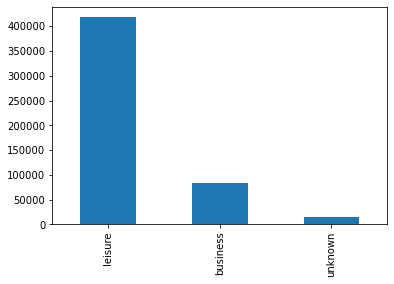

In [3]:
df.trip_type.value_counts().plot.bar()

<AxesSubplot:>

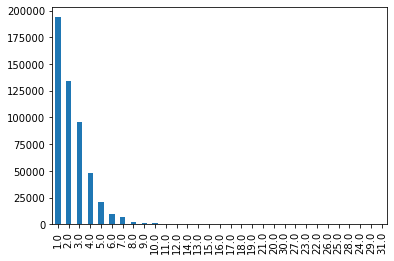

In [4]:
df.nights_stayed.value_counts().plot.bar()

<AxesSubplot:>

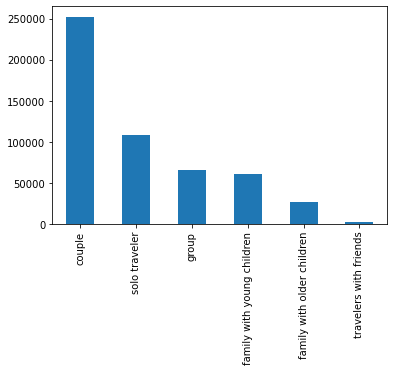

In [5]:
df.group_type.value_counts().plot.bar()

<AxesSubplot:ylabel='Frequency'>

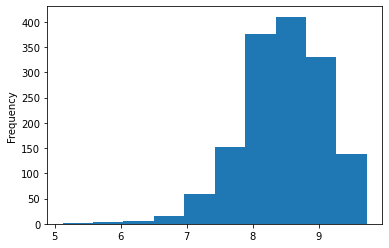

In [6]:
df.groupby(df.hotel_name).reviewer_score.mean().plot.hist()

### Exploration - Natural Language Processing

- Notes...

In [8]:
df.positive_clean_review.fillna('', inplace=True)
df.negative_clean_review.fillna('', inplace=True)

pos_reviews = ' '.join(df.positive_clean_review)
pos_reviews = pos_reviews.split()

neg_reviews = ' '.join(df.negative_clean_review) 
neg_reviews = neg_reviews.split()

<AxesSubplot:>

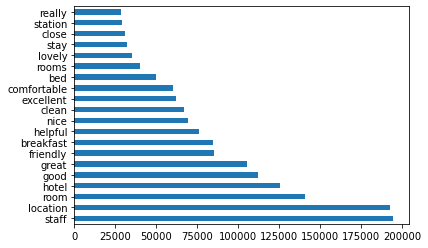

In [9]:
pd.Series(pos_reviews).value_counts().head(20).plot.barh()

<AxesSubplot:>

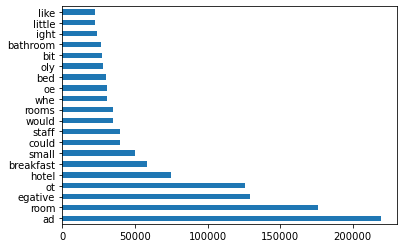

In [10]:
pd.Series(neg_reviews).value_counts().head(20).plot.barh()

In [11]:
#positive review bigrams
pos_bigrams = (pd.Series(nltk.ngrams(pos_reviews, 2)).value_counts().head(20))
pos_bigrams.head(20)

(great, location)        30992
(friendly, staff)        25238
(staff, friendly)        24828
(friendly, helpful)      21450
(good, location)         21091
(helpful, staff)         17820
(staff, helpful)         16788
(excellent, location)    12891
(location, great)        12811
(location, good)         11604
(location, staff)         9457
(breakfast, good)         9417
(good, breakfast)         9335
(comfortable, bed)        9006
(location, excellent)     8936
(staff, great)            8832
(room, clean)             8601
(walking, distance)       8406
(bed, comfortable)        7481
(helpful, friendly)       7368
dtype: int64

In [12]:
#negative review bigrams
neg_bigrams = (pd.Series(nltk.ngrams(neg_reviews, 2)).value_counts().head(20))
neg_bigrams.head(20)

(egative, egative)      35243
(room, small)            9467
(ad, ot)                 8819
(room, ad)               8319
(egative, room)          7903
(room, ot)               7116
(small, ad)              6486
(room, service)          6287
(small, room)            5828
(air, coditioig)         5548
(could, bee)             5427
(would, bee)             4956
(could, ot)              4657
(bookig, com)            4470
(star, hotel)            3994
(ot, workig)             3969
(egative, breakfast)     3909
(room, egative)          3753
(staff, ot)              3751
(breakfast, ot)          3647
dtype: int64

In [13]:
#positive review trigrams
pos_trigrams = (pd.Series(nltk.ngrams(pos_reviews, 3)).value_counts().head(20))
pos_trigrams.head(20)

(staff, friendly, helpful)     9667
(friendly, helpful, staff)     7191
(location, friendly, staff)    4081
(staff, helpful, friendly)     3189
(staff, great, location)       3170
(hotel, great, location)       2777
(good, value, money)           2553
(within, walking, distance)    2403
(friendly, staff, good)        2080
(would, definitely, stay)      2049
(staff, good, location)        2019
(friendly, staff, great)       2008
(helpful, friendly, staff)     1977
(staff, extremely, helpful)    1960
(great, location, friendly)    1760
(nothing, much, trouble)       1639
(hotel, good, location)        1561
(location, great, staff)       1524
(location, great, location)    1500
(location, staff, friendly)    1455
dtype: int64

In [14]:
#negative review trigrams
neg_trigrams = (pd.Series(nltk.ngrams(neg_reviews, 3)).value_counts().head(20))
neg_trigrams.head(20)

(egative, egative, egative)      10020
(egative, egative, room)          2114
(4, star, hotel)                  1913
(room, small, ad)                 1838
(would, bee, ice)                 1754
(tea, ad, coffee)                 1456
(could, bee, better)              1348
(egative, room, small)            1337
(room, bit, small)                1164
(egative, egative, breakfast)     1069
(breakfast, ot, icluded)          1049
(room, egative, egative)           999
(room, little, small)              907
(5, star, hotel)                   875
(coffee, makig, facilities)        873
(egative, small, room)             788
(room, quite, small)               765
(makig, facilities, room)          760
(staff, ot, friedly)               694
(egative, egative, ot)             670
dtype: int64

In [15]:
#positive review n-grams = 4
pos_quadgrams = (pd.Series(nltk.ngrams(pos_reviews, 4)).value_counts().head(20))
pos_quadgrams.head(20)

(great, location, friendly, staff)        1187
(location, friendly, helpful, staff)      1069
(friendly, staff, great, location)        1037
(staff, friendly, helpful, room)           830
(staff, friendly, helpful, location)       812
(friendly, staff, good, location)          745
(good, location, friendly, staff)          711
(helpful, staff, great, location)          683
(staff, extremely, friendly, helpful)      603
(location, staff, friendly, helpful)       568
(friendly, helpful, staff, great)          567
(friendly, helpful, staff, good)           541
(excellent, location, friendly, staff)     538
(hotel, staff, friendly, helpful)          508
(staff, really, friendly, helpful)         486
(staff, friendly, helpful, breakfast)      466
(friendly, helpful, staff, location)       444
(helpful, staff, good, location)           426
(friendly, staff, excellent, location)     425
(staff, friendly, helpful, hotel)          417
dtype: int64

In [16]:
#negative review n-grams = 4
neg_quadgrams = (pd.Series(nltk.ngrams(neg_reviews, 4)).value_counts().head(20))
neg_quadgrams.head(20)

(egative, egative, egative, egative)      2978
(egative, egative, egative, room)          589
(coffee, makig, facilities, room)          516
(tea, coffee, makig, facilities)           487
(egative, egative, room, small)            382
(sigle, beds, pushed, together)            314
(ot, 4, star, hotel)                       307
(egative, egative, egative, breakfast)     302
(tea, ad, coffee, makig)                   283
(egative, room, small, ad)                 272
(room, egative, egative, egative)          269
(tea, ad, coffee, facilities)              269
(breakfast, could, bee, better)            261
(would, ot, stay, agai)                    256
(ad, coffee, makig, facilities)            252
(egative, egative, small, room)            248
(tea, coffee, facilities, room)            232
(egative, room, bit, small)                231
(air, coditioig, ot, workig)               225
(tea, makig, facilities, room)             213
dtype: int64

In [17]:
#positive review n-grams = 5
pos_pentagrams = (pd.Series(nltk.ngrams(pos_reviews, 5)).value_counts().head(20))
pos_pentagrams.head(20)

(great, location, friendly, helpful, staff)        319
(friendly, helpful, staff, great, location)        299
(staff, friendly, helpful, great, location)        212
(staff, friendly, helpful, room, clean)            178
(friendly, helpful, staff, good, location)         177
(excellent, location, friendly, helpful, staff)    165
(good, location, friendly, helpful, staff)         151
(great, location, staff, friendly, helpful)        125
(staff, friendly, helpful, good, location)         119
(staff, friendly, helpful, breakfast, good)        114
(staff, friendly, helpful, location, great)        113
(friendly, helpful, staff, good, breakfast)        113
(location, great, staff, friendly, helpful)        103
(great, location, within, walking, distance)       100
(friendly, helpful, staff, excellent, location)     99
(great, location, friendly, staff, good)            96
(staff, friendly, helpful, location, excellent)     90
(great, location, friendly, staff, clean)           85
(location,

In [18]:
#negative review n-grams = 5
neg_pentagrams = (pd.Series(nltk.ngrams(neg_reviews, 5)).value_counts().head(20))
neg_pentagrams.head(20)

(egative, egative, egative, egative, egative)      912
(tea, coffee, makig, facilities, room)             296
(tea, ad, coffee, makig, facilities)               241
(two, sigle, beds, pushed, together)               178
(egative, egative, egative, egative, room)         176
(ad, coffee, makig, facilities, room)              141
(tea, ad, coffee, facilities, room)                137
(egative, egative, egative, room, small)           114
(2, sigle, beds, pushed, together)                 106
(egative, egative, egative, egative, breakfast)     80
(room, egative, egative, egative, egative)          75
(egative, egative, room, small, ad)                 75
(bed, two, sigles, pushed, together)                69
(egative, egative, egative, small, room)            57
(two, sigle, beds, put, together)                   56
(coffee, makig, facilities, room, egative)          55
(egative, egative, room, bit, small)                53
(egative, egative, egative, egative, rooms)         53
(defiitely

# Visualize sentiment scores ???

# Topic Modeling ?? visualize ??

---

### Net Promoter Scores (NPS):

- Notes...

In [19]:
def hotel_nps_score(series):
    score = ((series == 'promoter').sum() - (series == 'detractor').sum()) / series.size
    score = round(score * 100)
    return score

In [20]:
hotel_df = pd.DataFrame(df.groupby(df.hotel_name).nps_group.apply(hotel_nps_score))
hotel_df.sort_values(by='nps_group', ascending=False)

,nps_group
hotel_name,
H10 Casa Mimosa 4 Sup,93
Ritz Paris,93
Hotel Casa Camper,93
The Soho Hotel,92
Bulgari Hotel London,92
...,...
Villa Eugenie,-52
Kube Hotel Ice Bar,-53
Savoy Hotel Amsterdam,-56
